In [1]:
import os
import re
import sys

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

from scipy import stats

import math

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import pickle
import xlrd
import pylab

In [2]:
# Helper (support)
from support import input_helper

In [3]:
# Directory with IGU datasets:
ROOT_DIR = "RawData"

# Specify path to dynamic stock model and to datafile, relative
MainPath = os.path.join('odym', 'modules')
DataPath = os.path.join('docs', 'files')
sys.path.insert(0, MainPath)  # add ODYM module directory to system path

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))
sys.path.insert(0, os.path.join(os.getcwd(), 'docs', 'files'))

# Define path to save figures:
path_img = (
    r'C:\Users\souvi\Documents\These\90_Presentations & Writting\50_Papers\2021_12_MEFA of IGU\IMG'
)

In [4]:
import ODYM_Classes as msc  # import the ODYM class file
import ODYM_Functions as msf  # import the ODYM function file
import dynamic_stock_model as dsm  # import the dynamic stock model library

In [5]:
# Define size of figure:
mpl.rcParams['figure.figsize'] = (16, 10)

In [6]:
# Define seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.5,
                rc={"axes.titlesize": 15, "lines.linewidth": 1.2,
                    "legend.fontsize": 10, "legend.title_fontsize": 10})

In [7]:
pd.set_option('precision', 2)

In [8]:
# A custom formatter function which divide by 1000 an axis:
def yfmt1000(x, pos): 
    s = f'{x/1000:,.0f}'
    return s

# W/ classes for tick-locating and -formatting:
import matplotlib.ticker as tkr

# A formatter function:
y_1000 = tkr.FuncFormatter(yfmt1000)

# To divide the y-axis by 1000 when needed:
# ax.yaxis.set_major_formatter(y_1000)

In [9]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

In [10]:
# A keyword to export figures, or not:
export = False

# Upload Datasets

In [11]:
BE_data = input_helper.get_data(
    'BE_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)
FR_data = input_helper.get_data(
    'FR_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)
EU_data = input_helper.get_data(
    'EU_IGU_RawData_VPython.xlsx', directory=ROOT_DIR)

In [12]:
print("BE_data, sheet names = \n {}\n".format(BE_data.sheet_names))
print("FR_data, sheet names = \n {}\n".format(FR_data.sheet_names))
print("EU_data, sheet names = \n {}\n".format(EU_data.sheet_names))

BE_data, sheet names = 
 ['prod', 'import', 'export', 'Population']

FR_data, sheet names = 
 ['References', 'prod', 'import', 'export', 'Population', 'MatEnergy_WindowGlass', 'MatEnergy_PlateGlass', 'RawMat_Intensity', 'Energy_Intensity', 'emissions']

EU_data, sheet names = 
 ['stock', 'prod', 'import', 'export']



# Material, Energy and Carbon Intensity in the Flat Glass Industry

See: Souviron and Khan. (Forthcoming). "The Materiality of Transparency: An Environmental Analysis of the Architectural Flat Glass Industry since 1945 in Europe, France and Belgium". Resources, Conservation and Recycling.

## Material intensity since 1945

In [13]:
# Create a DataFrame for material intensity:
MatIntensity = FR_data.parse('RawMat_Intensity').set_index('year')

MatIntensity['cullet, kg/kg'] = (MatIntensity['internal cullet, kg/kg']
                                 + MatIntensity['external cullet, kg/kg'])

In [14]:
# List of raw materials:
materials = ['sand', 'cullet', 'sodium carbonate',
             'limestone', 'dolomite', 'feldspar']

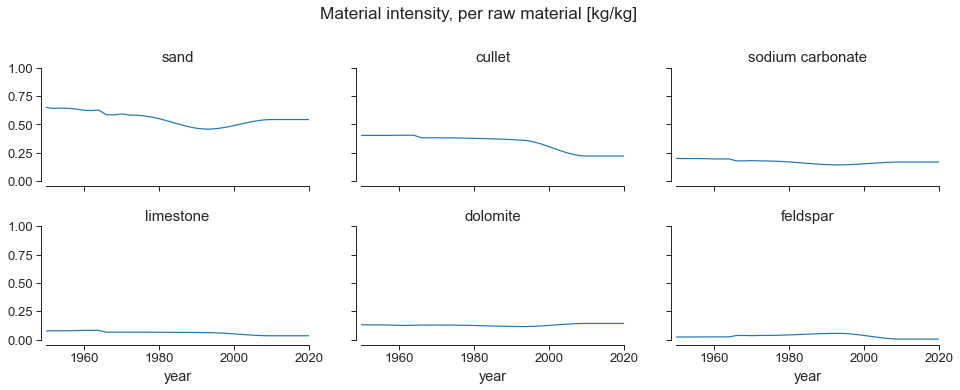

In [15]:
# Plot raw materials intensity since 1945:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    ax.set_title(mat)
    (MatIntensity[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax)
     )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("Material intensity, per raw material [kg/kg]", y=1.05)
fig.subplots_adjust(hspace=0.4)

sns.despine(offset=5)
plt.show()

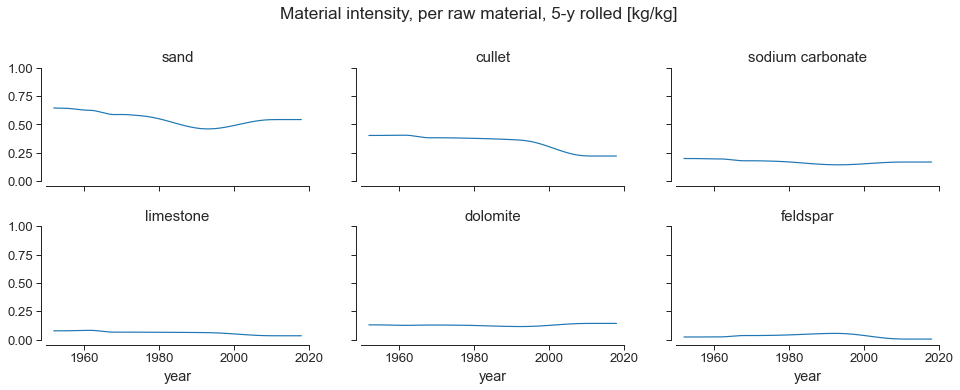

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    ax.set_title(mat)
    (MatIntensity[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

fig.suptitle("Material intensity, per raw material, 5-y rolled [kg/kg]", 
             y=1.05)
fig.subplots_adjust(hspace=0.4)

sns.despine(offset=5)
plt.show()

In [17]:
# Estimate the material intensity (sum of the intenisities per material):
MatIntensity['Total raw materials, kg/kg'] = 0

for mat in materials:
    MatIntensity['Total raw materials, kg/kg'] = (
        MatIntensity[f"{mat}, kg/kg"]
        + MatIntensity['Total raw materials, kg/kg']
    )

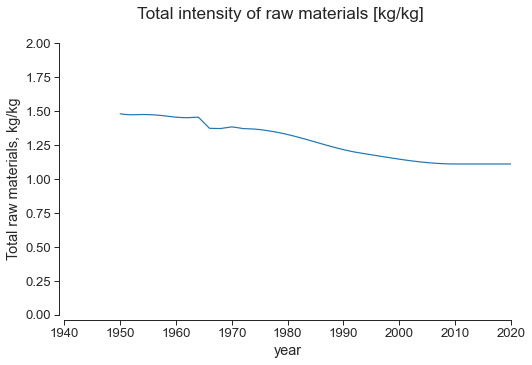

In [18]:
# Plot the material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=MatIntensity,
             x=MatIntensity.index,
             y=(MatIntensity['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax)

ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw materials [kg/kg]")

sns.despine(offset=5)
plt.show()

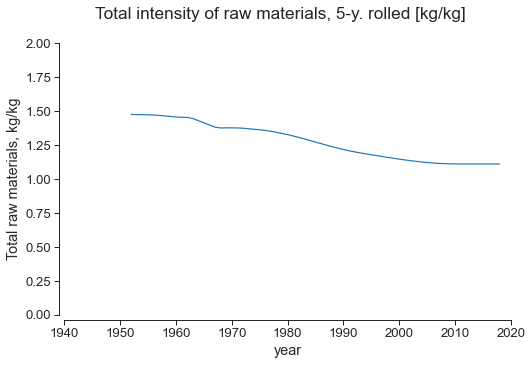

In [19]:
# Plot a 5-y rolled material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=MatIntensity,
             x=MatIntensity.index,
             y=(MatIntensity['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax)

ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw materials, 5-y. rolled [kg/kg]")

sns.despine(offset=5)
plt.show()

In [20]:
matwocullet = ['sand', 'sodium carbonate', 'limestone',
               'dolomite', 'feldspar']

In [21]:
# Estimate the material intensity without cullet:
MatIntensity['Total raw mat w/o cullet, kg/kg'] = 0

for mat in matwocullet:
    MatIntensity['Total raw mat w/o cullet, kg/kg'] = (
        MatIntensity[f"{mat}, kg/kg"]
        + MatIntensity['Total raw mat w/o cullet, kg/kg']
    )

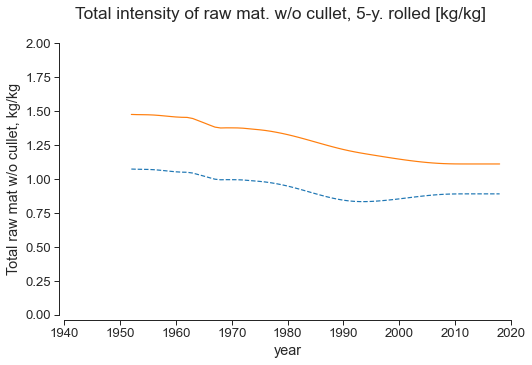

In [22]:
# Plot a 5-y rolled material intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=MatIntensity,
             x=MatIntensity.index,
             y=(MatIntensity['Total raw mat w/o cullet, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax, linestyle='--')

sns.lineplot(data=MatIntensity,
             x=MatIntensity.index,
             y=(MatIntensity['Total raw materials, kg/kg']
                .interpolate(method='pchip', limit_direction='forward')
                 .rolling(5, center=True).mean()),
             ax=ax)

ax.set_xlim(1940, 2020)
ax.set_ylim(0, 2)

fig.suptitle("Total intensity of raw mat. w/o cullet, 5-y. rolled [kg/kg]")

sns.despine(offset=5)
plt.show()

## Energy Intensity since 1945

In [23]:
# Create a DataFrame for energy intensity:
EnergyIntensity = FR_data.parse('Energy_Intensity').set_index('year')

In [24]:
energies = ['fuel oil', 'natural gas', 'electricity']

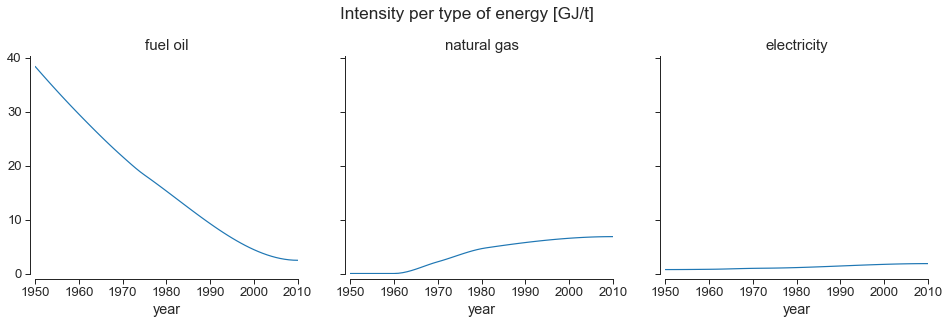

In [25]:
# Plot the intensity per type of energy:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    ax.set_title(energy)
    (EnergyIntensity[f"{energy}, GJ/t"] # Interpolate:
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax))

ax.set_xlim(1950, 2010)
ax.set_ylim(ymin=0)

fig.suptitle("Intensity per type of energy [GJ/t]", y=1.05)

sns.despine(offset=5)
plt.show()

In [26]:
# Estimate the energy intensity (sum of the intensities per type of energy):
EnergyIntensity['Total energy, GJ/t'] = 0

for energy in energies:
    EnergyIntensity['Total energy, GJ/t'] = (
        EnergyIntensity['Total energy, GJ/t']
        + EnergyIntensity[f"{energy}, GJ/t"]
    )

In [27]:
fossilfuels = ['fuel oil', 'natural gas']

In [28]:
# Estimate the energy intensity (sum of the intensities per type of energy):
EnergyIntensity['Total energy w/o elec., GJ/t'] = 0

for energy in fossilfuels:
    EnergyIntensity['Total energy w/o elec., GJ/t'] = (
        EnergyIntensity['Total energy w/o elec., GJ/t']
        + EnergyIntensity[f"{energy}, GJ/t"]
    )

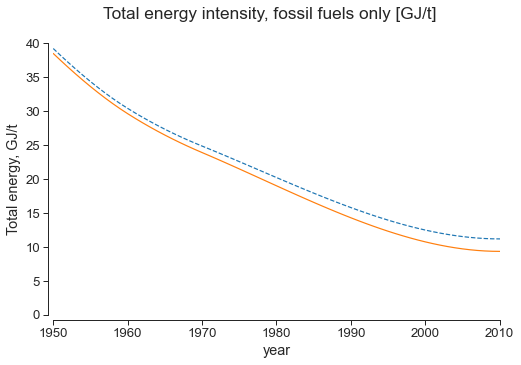

In [29]:
# Plot the total energy intensity:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EnergyIntensity,
             x=EnergyIntensity.index,
             y=(EnergyIntensity['Total energy, GJ/t']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax, linestyle='--')

sns.lineplot(data=EnergyIntensity,
             x=EnergyIntensity.index,
             y=(EnergyIntensity['Total energy w/o elec., GJ/t']
                .interpolate(method='pchip', limit_direction='forward')),
             ax=ax)

ax.set_xlim(1950, 2010)
ax.set_ylim(0, 40)

fig.suptitle("Total energy intensity, fossil fuels only [GJ/t]")

sns.despine(offset=5)
plt.show()

##  Carbon Intensity of the Flat Glass Production Process

In [30]:
# Create a DataFrame only with the CO2 emission data:
Emissions = FR_data.parse('emissions').set_index('year')

CO2_Intensity = Emissions[['CO2 glass ind, kg/t']].copy()
CO2_Intensity.rename(columns={'CO2 glass ind, kg/t': 'CO2 [kg/t]'},
                     inplace=True)

CO2_Intensity.dropna()

,CO2 [kg/t]
year,
1947,2100.0
1950,2050.0
1960,1725.0
1965,1525.0
1970,1340.0
1975,1075.0
1980,900.0
1985,800.0
1990,690.0


In [31]:
# Interpolate CO2 intensity accoring to a pchip method:
CO2_Intensity['CO2 interpolated [kg/t]'] = (
    CO2_Intensity['CO2 [kg/t]'].interpolate('pchip')
)

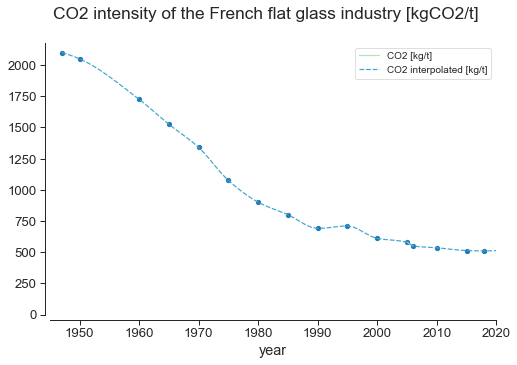

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=CO2_Intensity, palette="GnBu")

ax.scatter(x=CO2_Intensity.index, y=CO2_Intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)
fig.suptitle("CO2 intensity of the French flat glass industry [kgCO2/t]")
sns.despine(offset=5)
plt.show()

## Summary

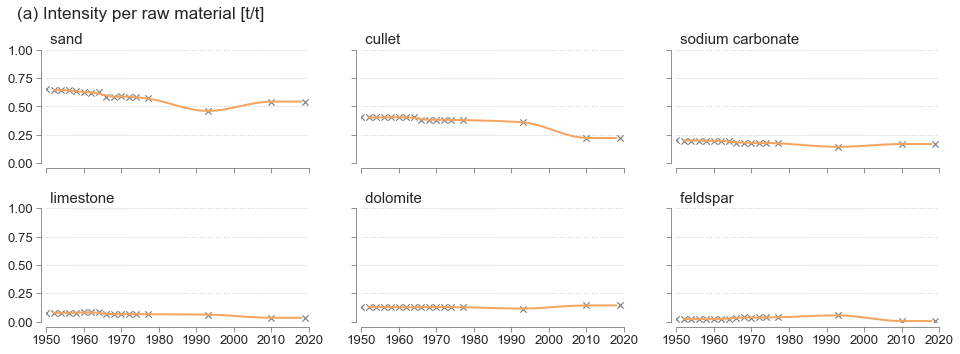

In [33]:
# Plot the material instensity per raw material:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):
    (MatIntensity[f"{mat}, kg/kg"]
     .interpolate(method='pchip', limit_direction='forward')
     .rolling(5, center=True).mean()
     .plot(ax=ax, c='sandybrown', linewidth=2))
    
    ax.scatter(x=MatIntensity.index, y=MatIntensity[f"{mat}, kg/kg"],
               s=40, marker='x', c='grey')
    plt.xticks(np.arange(1950, 2021, 10), rotation=45)

    ax.set_title(f" {mat}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 1)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(a) Intensity per raw material [t/t]", x=0.1, y=1, ha='left')
fig.subplots_adjust(wspace=0.2, hspace=0.4)

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig4_Mat Intensity.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig4_Mat Intensity.pdf'),
                bbox_inches='tight')
    
plt.show()

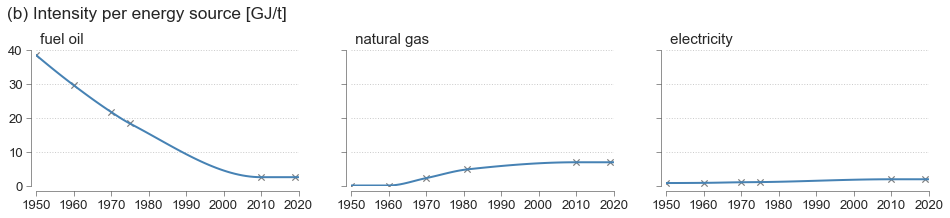

In [34]:
# Plot the energy intensity per source of energy:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 2.5)
                         )

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    (EnergyIntensity[f"{energy}, GJ/t"]
     .interpolate(method='pchip', limit_direction='forward')
     .plot(ax=ax, color='steelblue', linewidth=2))
    
    ax.scatter(x=EnergyIntensity.index, y=EnergyIntensity[f"{energy}, GJ/t"],
               s=40, marker='x', c='grey')
    
    ax.set_title(f" {energy}", loc='left')
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    style_ax(ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)

fig.suptitle("(b) Intensity per energy source [GJ/t]",
             x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.2)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig4_Energy Intensity.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig4_Energy Intensity.pdf'), 
                bbox_inches='tight')
    
plt.show()

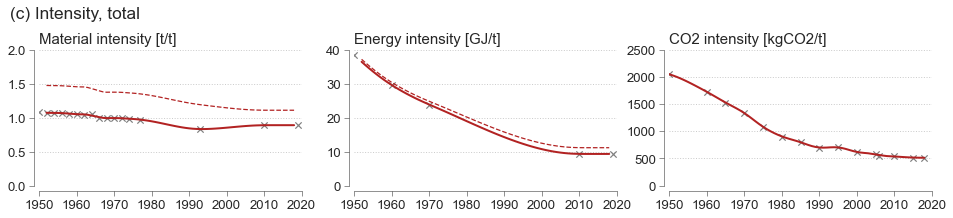

In [35]:
# Plot the intensity for energy, material and CO2 emissions:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True,
                         figsize=(16, 2.5))

# Material intensity
ax = axes[0]
(MatIntensity['Total raw materials, kg/kg']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25)
 )

(MatIntensity['Total raw mat w/o cullet, kg/kg']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='-', linewidth=2)
 )

ax.scatter(x=MatIntensity.index, 
           y=MatIntensity['Total raw mat w/o cullet, kg/kg'],
           s=40, marker='x', c='grey')

ax.set_title("Material intensity [t/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 2)
ax.set_xlim(1950, 2020)

# Energy intensity
ax = axes[1]
(EnergyIntensity['Total energy, GJ/t']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linestyle='--', linewidth=1.25))

(EnergyIntensity['Total energy w/o elec., GJ/t']
 .interpolate(method='pchip', limit_direction='forward')
 .rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=EnergyIntensity.index, 
           y=EnergyIntensity['Total energy w/o elec., GJ/t'],
           s=40, marker='x', c='grey')

ax.set_title("Energy intensity [GJ/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 40)

# Carbon dioxide intensity
ax = axes[2]
(CO2_Intensity['CO2 interpolated [kg/t]'].rolling(5, center=True).mean()
 .plot(ax=ax, c='firebrick', linewidth=2))

ax.scatter(x=CO2_Intensity.index, y=CO2_Intensity['CO2 [kg/t]'],
           s=40, marker='x', c='grey')

ax.set_title("CO2 intensity [kgCO2/t]", loc='left')
ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)
ax.set_ylim(0, 2500)

ax.minorticks_off()
plt.xticks(np.arange(1950, 2021, 10))

fig.suptitle("(c) Intensity, total", x=0.1, y=1.12, ha='left')
fig.subplots_adjust(wspace=0.20)

sns.despine(offset=5)

if export:
    # Save image:
    plt.savefig(os.path.join(path_img, 'Fig4_TotalIntensity.png'),
                dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(path_img, 'Fig4_TotalIntensity.pdf'),
                bbox_inches='tight')

plt.show()

# Flows of Insulating Glass Units in Europe

## Creating a Dataframe for the Flows of IGU

In [36]:
# Data relating to IGU production:
EU_Prod = EU_data.parse('prod').set_index(['Nbr of countries', 'year'])

In [37]:
# Add import and export flows:
EU_Imp = EU_data.parse('import').set_index(['Nbr of countries', 'year'])
EU_Exp = EU_data.parse('export').set_index(['Nbr of countries', 'year'])

In [38]:
# Create a new DataFrame for European IGU flows:
EU_IGU = pd.concat([EU_Prod['IGU, "000 m²']/1000,
                    EU_Imp['IGU, "000 m²']/1000,
                    EU_Exp['IGU, "000 m²']/1000],
                   axis=1, keys=[('Production', '[10^6 m²]'),
                                 ('Import', '[10^6 m²]'),
                                 ('Export', '[10^6 m²]')],
                   names=['Info', 'Unit']).stack(dropna=False)

EU_IGU = EU_IGU.unstack()

In [51]:
EU_IGU.style

In [40]:
# Adding columns for data in [kt],
# to be used later for material/energy/carbon intensity
# 2500kg/m³ and in average 9mm thick

EU_IGU[('Production', '[kt]')] = EU_IGU[('Production', '[10^6 m²]')] * 2.5 * 9
EU_IGU[('Import', '[kt]')] = EU_IGU[('Import', '[10^6 m²]')] * 2.5 * 9
EU_IGU[('Export', '[kt]')] = EU_IGU[('Export', '[10^6 m²]')] * 2.5 * 9

EU_IGU = EU_IGU.sort_index(axis=1)

## Production of Insulating Glass Units

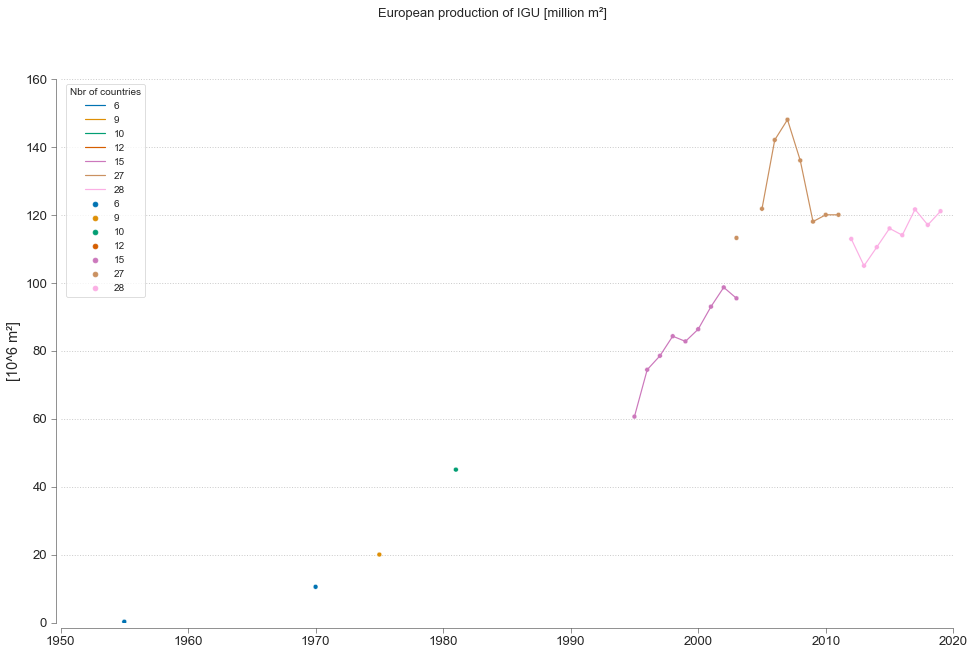

In [41]:
# Plot the European production of flat glass
fig, ax = plt.subplots()

sns.scatterplot(data=EU_IGU['Production'].reset_index(),
                x='year', y='[10^6 m²]',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

sns.lineplot(data=EU_IGU['Production'].reset_index(),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)

fig.suptitle('European production of IGU [million m²]', fontsize=13)
sns.despine(offset=5)
plt.show()

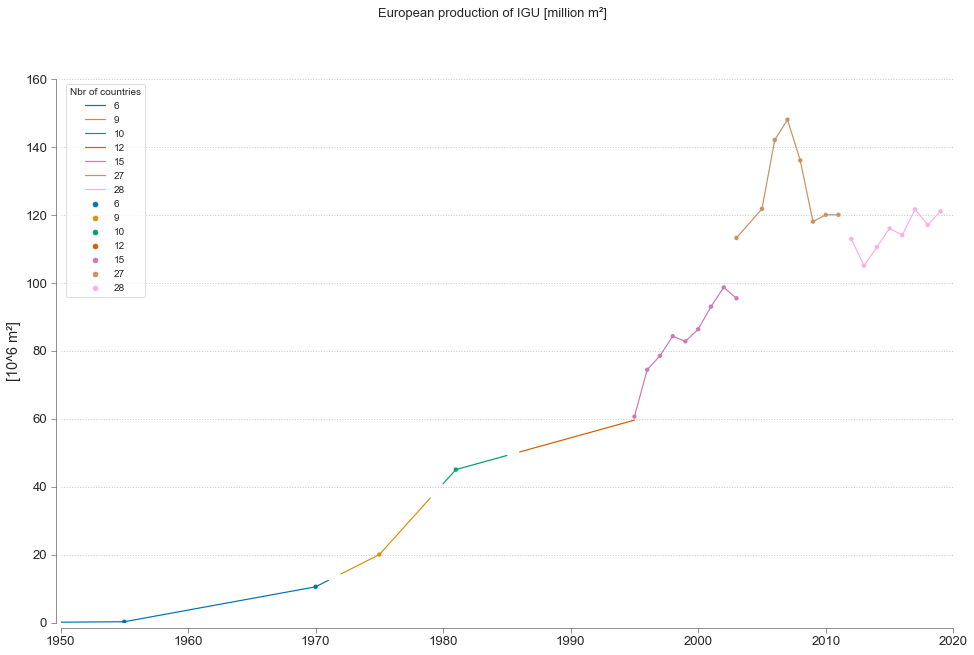

In [42]:
# Plot the European production of flat glass
fig, ax = plt.subplots()

sns.scatterplot(data=EU_IGU['Production'].reset_index(),
                x='year', y='[10^6 m²]',
                hue='Nbr of countries',
                palette='colorblind',
                ax=ax)

sns.lineplot(data=EU_IGU['Production'].interpolate(method='linear').reset_index(),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
style_ax(ax)

fig.suptitle('European production of IGU [million m²]', fontsize=13)
sns.despine(offset=5)
plt.show()

## Consumption of Insulating Glass Units

In [43]:
# Estimate the consumption of IGU in the EU:
EU_IGU = EU_IGU.stack()

EU_IGU['Consumption'] = (EU_IGU['Production']
                         + EU_IGU['Import']
                         - EU_IGU['Export']
                         )

EU_IGU = EU_IGU.unstack()

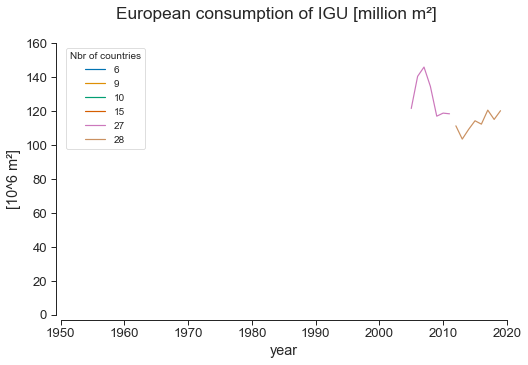

In [44]:
# Plot the European consumption of IGU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EU_IGU['Consumption'].reset_index(),
             x='year', y='[10^6 m²]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 160)

fig.suptitle('European consumption of IGU [million m²]')
sns.despine(offset=5)
plt.show()

## Summary

In [45]:
# Key dates for the changes in the MFA scope, i.e. EU enlargement:
EU_Kdates = {'EU6': 1972, 'EU10': 1980, 'EU12': 1986, 
             'EU15': 1995, 'EU27': 2003, 'EU28': 2012}

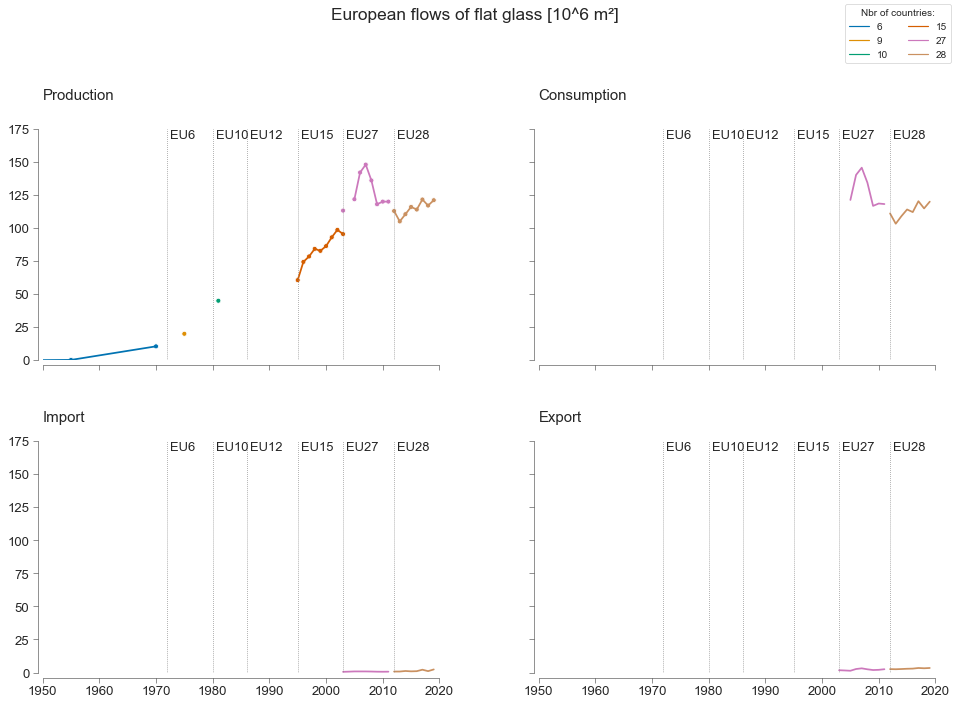

In [46]:
# Plot a synthesis of the results concerning European flows of IGU:
data1 = ['Production', 'Consumption']
data2 = ['Import', 'Export']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 10))

# Plot production and consumption:
for col, data in enumerate(data1):
    ax = axes[0][col]
    sns.lineplot(data=EU_IGU[f"{data}"].reset_index(),
                 x='year', y="[10^6 m²]",
                 hue='Nbr of countries',
                 palette='colorblind', linewidth=1.75,
                 ax=ax)

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in EU_Kdates.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 175, f"{y}", fontsize=13,
                verticalalignment='top')
    
    if col == 0:
        # Plot data gathered from literature review:
        sns.scatterplot(data=EU_IGU[f"{data}"].reset_index(),
                        x='year', y="[10^6 m²]",
                        hue='Nbr of countries',
                        palette='colorblind',
                        marker='.', s=100,
                        ax=ax)
        
    ax.get_legend().remove()
    style_ax(ax)

    ax.set_title(f"{data}", pad=30, loc='left')
    #ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    #ax.get_legend().remove()
    ax.yaxis.label.set_visible(False)

# Plot import and export below:
for col, data in enumerate(data2):
    ax = axes[1][col]
    sns.lineplot(data=EU_IGU[f"{data}"].reset_index(),
                 x='year', y="[10^6 m²]",
                 hue='Nbr of countries',
                 palette='colorblind', linewidth=1.75,
                 ax=ax)

    # Plot lines highlighting changes in the scope, i.e., EU enlargement:
    for y, x in EU_Kdates.items():
        ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
        ax.text(x+0.5, 175, f"{y}", fontsize=13,
                verticalalignment='top')

    style_ax(ax)

    ax.set_title(f"{data}", pad=20, loc='left')
    #ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.get_legend().remove()
    ax.yaxis.label.set_visible(False)


# Add legend:
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2,
           title='Nbr of countries:',
           bbox_to_anchor=(0.83, 0.98))

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 175)

fig.suptitle("European flows of flat glass [10^6 m²]", y=1.05)
fig.subplots_adjust(wspace=0.25, hspace=0.35)

sns.despine(offset=5)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixB_EU_IGUFlows.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixB_EU_IGUFlows.pdf'),
                bbox_inches='tight')

Hypothesis for missing data: EU production = EU consumption

In [63]:
EU_IGU

Info                     Export           Import        Production           \
Unit                  [10^6 m²]   [kt] [10^6 m²]   [kt]  [10^6 m²]     [kt]   
Nbr of countries year                                                         
6                1947      0.00   0.00      0.00   0.00       0.00     0.00   
                 1955       NaN    NaN       NaN    NaN       0.23     5.06   
                 1970       NaN    NaN       NaN    NaN      10.50   236.25   
9                1975       NaN    NaN       NaN    NaN      20.00   450.00   
10               1981       NaN    NaN       NaN    NaN      45.00  1012.50   
15               1995       NaN    NaN       NaN    NaN      60.60  1363.50   
                 1996       NaN    NaN       NaN    NaN      74.40  1674.00   
                 1997       NaN    NaN       NaN    NaN      78.50  1766.25   
                 1998       NaN    NaN       NaN    NaN      84.27  1896.00   
                 1999       NaN    NaN       NaN    NaN      82.74  1861.74   
                 2000       NaN    NaN       NaN    NaN      86.33  1942.44   
                 2001       NaN    NaN       NaN    NaN      92.97  2091.75   
                 2002       NaN    NaN       NaN    NaN      98.64  2219.45   
                 2003       NaN    NaN       NaN    NaN      95.43  2147.07   
27               2003      1.72  38.76      0.51  11.47     113.19  2546.84   
                 2004      1.54  34.76      0.65  14.54        NaN      NaN   
                 2005      1.33  29.84      0.81  18.31     121.77  2739.81   
                 2006      2.64  59.42      0.81  18.23     142.03  3195.60   
                 2007      3.15  70.85      0.80  18.10     148.00  3330.00   
                 2008      2.42  54.52      0.73  16.48     136.00  3060.00   
                 2009      1.87  42.03      0.62  13.92     118.00  2655.00   
                 2010      2.03  45.58      0.58  12.99     120.00  2700.00   
                 2011      2.48  55.81      0.62  14.03     120.00  2700.00   
28               2012      2.57  57.88      0.72  16.25     112.90  2540.36   
                 2013      2.47  55.64      0.73  16.40     105.00  2362.50   
                 2014      2.63  59.14      1.14  25.69     110.47  2485.50   
                 2015      2.83  63.76      0.87  19.66     116.00  2610.00   
                 2016      2.94  66.18      1.00  22.54     114.00  2565.00   
                 2017      3.41  76.65      2.12  47.64     121.60  2736.00   
                 2018      3.20  71.90      1.02  22.95     117.01  2632.76   
                 2019      3.42  76.85      2.32  52.15     121.06  2723.88   

Info                  Consumption          Estimated consumption           
Unit                    [10^6 m²]     [kt]             [10^6 m²]     [kt]  
Nbr of countries year                                                      
6                1947        0.00     0.00                  0.00     0.00  
                 1955         NaN      NaN                  0.23     5.06  
                 1970         NaN      NaN                 10.50   236.25  
9                1975         NaN      NaN                 20.00   450.00  
10               1981         NaN      NaN                 45.00  1012.50  
15               1995         NaN      NaN                 60.60  1363.50  
                 1996         NaN      NaN                 74.40  1674.00  
                 1997         NaN      NaN                 78.50  1766.25  
                 1998         NaN      NaN                 84.27  1896.00  
                 1999         NaN      NaN                 82.74  1861.74  
                 2000         NaN      NaN                 86.33  1942.44  
                 2001         NaN      NaN                 92.97  2091.75  
                 2002         NaN      NaN                 98.64  2219.45  
                 2003         NaN      NaN                 95.43  2147.07  
27               2003

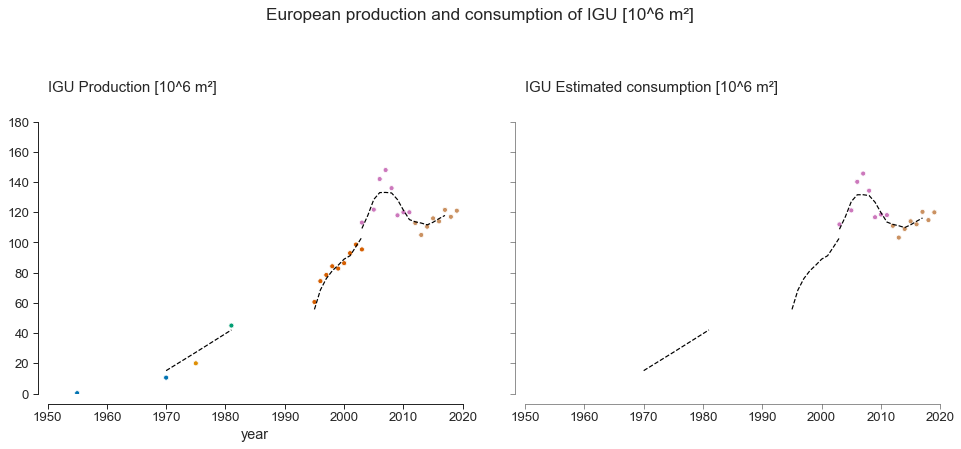

In [61]:
# Plot the European production and consumption of IGU in the EU:
data = ['Production', 'Estimated consumption']

# Plot two figures:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

# Number of countries for trend curves:
EU_list = [(6, 12), (15, 15), (27, 28)]

for col, data in enumerate(data):
    for i, j in EU_list:
        ax = axes[col]
        # Plot the trend curve for flat glass production:
        ax.plot(EU_IGU.interpolate().rolling(5, center=True).mean().loc[i:j]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [(f"{data}", "[10^6 m²]")],
                c='black', linestyle='--')

        if col == 0:
            # Plot data gathered from literature review:
            sns.scatterplot(data=EU_IGU["Production"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)
        else:
            # Plot data gathered from literature review:
            sns.scatterplot(data=EU_IGU["Consumption"].reset_index(),
                            x='year', y="[10^6 m²]",
                            hue='Nbr of countries',
                            palette='colorblind',
                            marker='.', s=100,
                            ax=ax)

        ax.get_legend().remove()
        ax.set_title(f'IGU {data} [10^6 m²]', pad=30, loc='left')
        ax.yaxis.label.set_visible(False)

# Plot lines highlighting changes in the scope, i.e., EU enlargement:
#for y, x in EU_Kdates.items():
#    ax.axvline(x=x, c='grey', linestyle=':', linewidth=0.75)
#    ax.text(x+0.5, 180, f"{y}", fontsize=14,
#            verticalalignment='top')

style_ax(ax)
ax.set_xlim(1950, 2020)
ax.set_ylim(0, 180)

plt.suptitle('European production and consumption of IGU [10^6 m²]',
             weight='light', y=1.2)

fig.subplots_adjust(wspace=0.15)

sns.despine(offset=10)
plt.show()

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'Fig2_EU_IGUProdConso.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'Fig2_EU_IGUProdConso.pdf'),
                bbox_inches='tight')

# Flows of Insulating Glass Units in France and Belgium

## Creating a Dataframe for the Flows of IGU

In [ ]:
# Create a DataFrame only with production data:
FR_Prod = FR_data.parse('prod').set_index('year')
BE_Prod = BE_data.parse('prod').set_index('year')

In [ ]:
# Create a DataFrame with import and export data:
FR_Imp = FR_data.parse('import').set_index('year')
FR_Exp = FR_data.parse('export').set_index('year')

BE_Imp = BE_data.parse('import').set_index('year')
BE_Exp = BE_data.parse('export').set_index('year')

In [ ]:
# Create a DataFrame with import and export data:
FR_Pop = FR_data.parse('Population').set_index('year')
BE_Pop = BE_data.parse('Population').set_index('year')

In [ ]:
# Create a unique DataFrame for French and Belgian population:
BE_FR_Pop = pd.concat([FR_Pop['Population, x1000'],
                       BE_Pop['Population, x1000']],
                      axis=1, keys=[('Population [x1000]', 'France'),
                                    ('Population [x1000]', 'Belgium')],
                      names=['Info', 'Country']).stack()

BE_FR_Pop = BE_FR_Pop.unstack()

In [ ]:
# Create a new DataFrame for Belgian and French IGU flows:
BE_FR_IGU = (
    pd.concat([FR_Prod['IGU, kt'], BE_Prod['IGU, kt'],
               FR_Prod['IGU, "000 m²']/1000, BE_Prod['IGU, "000 m²']/1000,
               FR_Imp['IGU, kt'], BE_Imp['IGU, kt'],
               FR_Imp['IGU, "000 m²']/1000, BE_Imp['IGU, "000 m²']/1000,
               FR_Exp['IGU, kt'], BE_Exp['IGU, kt'],
               FR_Exp['IGU, "000 m²']/1000, BE_Exp['IGU, "000 m²']/1000],
              axis=1,
              keys=[('Production [kt]', 'France'),
                    ('Production [kt]', 'Belgium'),
                    ('Production [10^6 m²]', 'France'),
                    ('Production [10^6 m²]', 'Belgium'),
                    ('Import [kt]', 'France'),
                    ('Import [kt]', 'Belgium'),
                    ('Import [10^6 m²]', 'France'),
                    ('Import [10^6 m²]', 'Belgium'),
                    ('Export [kt]', 'France'),
                    ('Export [kt]', 'Belgium'),
                    ('Export [10^6 m²]', 'France'),
                    ('Export [10^6 m²]', 'Belgium')],
              names=['Info', 'Country'])).stack(level=- 1,
                                                dropna=False)

BE_FR_IGU = BE_FR_IGU.unstack()

In [ ]:
BE_FR_IGU

## Production of Insulating Glass Units

In [ ]:
countries = ['Belgium', 'France']

In [ ]:
# Plot the BE and FR production of IGU:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(BE_FR_IGU['Production [10^6 m²]'].index,
            BE_FR_IGU['Production [10^6 m²]'][country])

    ax.set_title(country, pad=20)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 18)

fig.suptitle('IGU production [10^6 m²/y]', y=1.1)
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot a moving average for IGU production:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(BE_FR_IGU['Production [10^6 m²]'].index,
            BE_FR_IGU['Production [10^6 m²]'][country]
            # Linear interpolation for flat glass production:
            .interpolate(method="linear", limit_area='inside')
            # Rolling flat glass production according to a 5-year mean:
            .rolling(5, center=True).mean())

    ax.set_title(country, y=1.05)
    ax.set_xlim(1950, 2020)
    ax.set_ylim(0, 18)
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

fig.suptitle('IGU production, rolled [10^6 m²/y]', fontsize=15, y=1.1)
sns.despine(offset=5)
plt.show()

## Consumption of Insulating Glass Units

In [ ]:
# Caculate import and export ratios relative to production:
BE_FR_IGU = BE_FR_IGU.stack()

BE_FR_IGU['Import Ratio'] = (BE_FR_IGU['Import [kt]'] 
                             / BE_FR_IGU['Production [kt]'])
BE_FR_IGU['Export Ratio'] = (BE_FR_IGU['Export [kt]'] 
                             / BE_FR_IGU['Production [kt]'])

BE_FR_IGU = BE_FR_IGU.unstack()

In [ ]:
ratios = ['Import', 'Export']

In [ ]:
# Plot import and export ratios for FR and BE:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True)

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        (BE_FR_IGU[(f"{ratio} Ratio", country)].plot(ax=ax))

        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)


ax.set_ylim(0, 1)
ax.set_xlim(1950, 2020)

fig.suptitle("Import and export of IGU compared to production [%]", 
             y=1.05)
sns.despine(offset=5)
plt.show()

In [ ]:
# Interpolation for missing data:
cols = [x for x in BE_FR_IGU.columns if x[0] in ['Import Ratio',
                                                 'Export Ratio']]

BE_FR_IGU[cols] = (BE_FR_IGU[cols].interpolate(method='linear'))

In [ ]:
BE_FR_IGU.loc[1970:1980, cols]

In [ ]:
# Plot import and export ratios, w/ a moving average (5-y. window length):
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True)

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        (BE_FR_IGU[(f"{ratio} Ratio", country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax))
        
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)

ax.set_xlim(1945, 2015)
ax.set_ylim(0, 1)

fig.suptitle("Import and export compared to production [%]")
sns.despine(offset=5)
plt.show()

In [ ]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True)

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        BE_FR_IGU[(f"{ratio} [10^6 m²]", country)].plot(ax=ax)
        
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 3)

fig.suptitle('Import and export of IGU, [10^6 m²]')
sns.despine(offset=5)
plt.show()

In [ ]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True)

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        (BE_FR_IGU[(f"{ratio} [10^6 m²]", country)]
         .interpolate(method='linear', limit_area='inside')
         .rolling(5, center=True).mean()
         .plot(ax=ax))

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        if row == 0:
            ax.set_title(country, y=1.1)
        if col == 0:
            ax.set_ylabel(ratio)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 2)

fig.suptitle('Import and export of IGU, [10^6 m²]')
sns.despine(offset=5)
plt.show()

In [ ]:
BE_FR_IGU = BE_FR_IGU.stack()

BE_FR_IGU['Consumption [kt]'] = (BE_FR_IGU['Production [kt]']
                                 + BE_FR_IGU['Import [kt]']
                                 - BE_FR_IGU['Export [kt]']
                                 )

BE_FR_IGU['Consumption [10^6 m²]'] = (BE_FR_IGU['Production [10^6 m²]']
                                     + BE_FR_IGU['Import [10^6 m²]']
                                     - BE_FR_IGU['Export [10^6 m²]']
                                     )

BE_FR_IGU = BE_FR_IGU.unstack()

In [ ]:
# Plot total consumption of IGU:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):

    ax.plot(BE_FR_IGU.index,
            BE_FR_IGU['Consumption [10^6 m²]'][country])
    ax.set_title(country)

ax.set_xlim(1940, 2020)
ax.set_ylim(ymin=0)

fig.suptitle('Flat glass Consumption [10^6 m²/y]', fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

In [ ]:
# Estimating the IGU consumption per capita
for country in BE_FR_IGU['Consumption [10^6 m²]'].columns:
    BE_FR_IGU[('Consumption [m²/cap]', country)] = (
        BE_FR_IGU[('Consumption [10^6 m²]', country)]*1000
        / BE_FR_Pop[('Population [x1000]', country)])

In [ ]:
# Linear interpolation for IGU consumption
# and moving average with a 5-year window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(BE_FR_IGU['Consumption [10^6 m²]'].index,
            BE_FR_IGU['Consumption [10^6 m²]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())
    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country)

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 20)

fig.suptitle('IGU Consumption, rolled [10^6 m²/y]', 
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

In [ ]:
# Linear interpolation for IGU consumption per capita
# and moving average with a 5-y. window length:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(16, 5),
                         sharex=True, sharey=True)

for i, (ax, country) in enumerate(zip(axes.flatten(), countries)):
    ax.plot(BE_FR_IGU['Consumption [m²/cap]'].index,
            BE_FR_IGU['Consumption [m²/cap]'][country]
            .interpolate(method="linear", limit_area='inside')
            .rolling(5, center=True).mean())

    ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
    ax.set_title(country, y=1.1)
    ax.set_xlim(1945, 2020)
    ax.set_ylim(0, 0.5)

fig.suptitle('IGU consumption, m² per capita, rolled',
             fontsize=15, y=1.05)
sns.despine(offset=5)
plt.show()

## Summary

In [ ]:
# Plot total import and export flows, moving average w/ a 5-y. window length:
toplot = ['Production', 'Export', 'Import', 'Consumption']
nrows = len(toplot)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(13, 14))

for row, data in enumerate(toplot):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'forestgreen'
            ax.set_title(f"{data} [10^6 m²]", loc='left', pad=15)
        else:
            color = 'steelblue'

        (BE_FR_IGU[(f"{data} [10^6 m²]", country)]
         .interpolate(method='linear')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color)
         )

        x = BE_FR_IGU[(f"{data} [10^6 m²]", country)].index
        y = (BE_FR_IGU[(f"{data} [10^6 m²]", country)]
             .interpolate(method='linear')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color=color, alpha=0.075)

        sns.scatterplot(data=BE_FR_IGU[f"{data} [10^6 m²]"][country],
                        marker='.', s=50, color='grey',
                        ax=ax)

        ax.get_legend().remove()

        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.set_ylabel(None)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 20)
plt.xticks(np.arange(1950, 2021, 10))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle("Flows of IGU [10^6 m²]", y=1)
sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixC_BEFR_IGUFlows.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixC_BEFR_IGUFlows.pdf'),
                bbox_inches='tight')

plt.show()

Hypothesis for missing data: French production = French consumption

In [ ]:
for country in countries:
    BE_FR_IGU[("Estimated consumption [10^6 m²]", country)] = 0

In [ ]:
BE_FR_IGU["Estimated consumption [10^6 m²]"] = (
    BE_FR_IGU["Consumption [10^6 m²]"]
    .fillna(BE_FR_IGU["Production [10^6 m²]"])
)

In [ ]:
# Plot total import and export flows, moving average w/ a 5-y. window length:
toplot = ['Production', 'Export', 'Import', 'Consumption']
nrows = len(toplot)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(13, 14))

for row, data in enumerate(toplot):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        # Define the color and title for the subplots:
        if country == 'Belgium':
            color = 'forestgreen'
            ax.set_title(f"{data} [10^6 m²]", loc='left', pad=15)
        else:
            color = 'steelblue'

        if row == 3:
            sns.lineplot(data=BE_FR_IGU[("Estimated consumption [10^6 m²]",
                                         country)]
                         .interpolate(method='linear')
                         .rolling(5, center=True).mean(),
                         linestyle='--', color='darkgrey', ax=ax)

        (BE_FR_IGU[(f"{data} [10^6 m²]", country)]
         .interpolate(method='linear')
         .rolling(5, center=True).mean()
         .plot(ax=ax, c=color)
         )

        x = BE_FR_IGU[(f"{data} [10^6 m²]", country)].index
        y = (BE_FR_IGU[(f"{data} [10^6 m²]", country)]
             .interpolate(method='linear')
             .rolling(5, center=True).mean())
        ax.fill_between(x, y, color=color, alpha=0.075)

        sns.scatterplot(data=BE_FR_IGU[f"{data} [10^6 m²]"][country],
                        marker='.', s=50, color='grey',
                        ax=ax)

        ax.get_legend().remove()

        ax.minorticks_off()
        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)
        style_ax(ax)
        ax.set_ylabel(None)

        ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

        if row == 0:
            ax.set_title(country, y=1.25)

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 20)
plt.xticks(np.arange(1950, 2021, 10))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle("Flows of IGU [10^6 m²]", y=1)
sns.despine(offset=5)

if export:
    # Save image:
    fig.savefig(os.path.join(path_img, 'AppendixC_BEFR_IGUFlows.png'),
                dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(path_img, 'AppendixC_BEFR_IGUFlows.pdf'),
                bbox_inches='tight')

plt.show()

# Environmental Footprint Relating to the Production of IGU in the EU

## Raw Material Use for IGU Production

In [ ]:
# Absolute use of raw materials for IGU production:
for mat in materials:
    EU_IGU[f"{mat}, production [kt]"] = (
        EU_IGU['Production [kt]']
        * (MatIntensity[(f"{mat}, kg/kg")]
           .interpolate(method='pchip', limit_direction='forward'))
    )

In [ ]:
# Plot raw material flows for IGU production in the EU:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    sns.lineplot(data=EU_IGU.reset_index(),
                 x='year', y=f"{material}, production [kt]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(material)
    ax.set_ylabel(None)
    style_ax(ax)
    ax.get_legend().remove()
    
ax.set_xlim(1950, 2020)
ax.set_ylim(0, 2000)

fig.suptitle("Raw material flows related to IGU production in the EU[kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot raw material flows for EU IGU production
fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10, 8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):
    for a, b in EU_list:
        ax.plot(EU_IGU.interpolate()
                .rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{material}, production [kt]"],
                linewidth=1.1, c='black', linestyle=':'
                )
        ax.set_title(material)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 2000)

fig.suptitle("Raw material flows relating to IGU production in the EU [kt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Estimate total use of raw materials (sum per material):
EU_IGU['Total raw materials, production [Mt]'] = 0

for material in materials:
    EU_IGU['Total raw materials, production [Mt]'] = (
        EU_IGU[f"{material}, production [kt]"]/1000
        + EU_IGU['Total raw materials, production [Mt]']
    )

In [ ]:
# Plot total material use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EU_IGU.reset_index(),
             x='year', y='Total raw materials, production [Mt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
ax.set_ylim(0,4)
ax.set_ylabel(None)
style_ax(ax)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for IGU production in the EU [Mt/y]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot total material use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_list:
    ax.plot(EU_IGU.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['Total raw materials, production [Mt]'],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 4)
style_ax(ax)

fig.suptitle("Total use of raw materials for IGU production in the EU [Mt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Energy use in the production of IGU

In [ ]:
# Absolute use of energy for IGU production:
for energy in energies:
    EU_IGU[f"{energy}, production [PJ]"] = (
        EU_IGU['Production [kt]']
        * (EnergyIntensity[f"{energy}, GJ/t"]
           .interpolate(method='pchip', limit_direction='forward'))/1000
    )

In [ ]:
# Plot energy used for EU flat glass production
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    sns.lineplot(data=EU_IGU.reset_index(),
                 x='year', y=f"{energy}, production [PJ]",
                 hue='Nbr of countries',
                 palette='colorblind',
                 ax=ax)
    ax.set_title(energy)
    ax.get_legend().remove()
    ax.set_ylabel(None)
    style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 25)

fig.suptitle("Energy used in the production of IGU in the EU [PJ]", y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot raw energy flows for IGU production:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16, 4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):
    for a, b in EU_list:
        ax.plot(EU_IGU.interpolate()
                .rolling(5, center=True).mean().loc[a:b]
                .reset_index(level='Nbr of countries')
                .sort_values(by=['year'])
                [f"{energy}, production [PJ]"],
                linewidth=1.1, c='black', linestyle=':'
                )
        ax.set_title(energy)
        style_ax(ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 25)

fig.suptitle("Raw material flows relating to IGU production in the EU [kt/y]", 
             y=1.1)
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
EU_IGU['Total energy, production [PJ]'] = 0

for energy in energies:
    EU_IGU['Total energy, production [PJ]'] = (
        EU_IGU[f"{energy}, production [PJ]"]
        + EU_IGU['Total energy, production [PJ]']
    )

In [ ]:
# Plot total energy use for EU flat glass production
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EU_IGU.reset_index(),
             x='year', y='Total energy, production [PJ]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)

ax.set_xlim(1950, 2020)
plt.xticks(np.arange(1950, 2021, 10))
ax.set_ylim(0, 40)
ax.get_legend().remove()
ax.set_ylabel(None)
style_ax(ax)

fig.suptitle("Total use of energy for IGU production in the EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Plot total energy use for IGU production in the EU:
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_list:
    ax.plot(EU_IGU.interpolate().rolling(5, center=True).mean()
            .loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['Total energy, production [PJ]'],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1950, 2020)
ax.set_ylim(0, 40)
style_ax(ax)

fig.suptitle("Total use of energy for IGU production in the EU [PJ]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

## Absolute CO2 Emissions relating to the production of IGU, EU

In [ ]:
# Estimating the CO2 emission related to IGU production
EU_IGU['CO2, production [kt]'] = (
    EU_IGU['Production [kt]']
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EU_IGU.reset_index(),
             x='year', y='CO2, production [kt]',
             hue='Nbr of countries',
             palette='colorblind',
             ax=ax)
ax.set_xlim(1980, 2020)
ax.set_ylim(0, 2000)
ax.get_legend().remove()

fig.suptitle("CO2 emissions for EU IGU production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5)
plt.show()

In [ ]:
# Estimating the CO2 emission related to IGU production
EU_IGU['CO2, production [kt]'] = (
    EU_IGU['Production [kt]'].interpolate()
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
)

In [ ]:
# Plot total energy use for EU flat glass production
fig, ax = plt.subplots(figsize=(8, 5))

for a, b in EU_list:
    ax.plot(EU_IGU.rolling(5, center=True).mean().loc[a:b]
            .reset_index(level='Nbr of countries')
            .sort_values(by=['year'])
            ['CO2, production [kt]'],
            linewidth=1.1, c='black', linestyle=':'
            )

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)

fig.suptitle("CO2 emissions for EU IGU production [kt]")
fig.subplots_adjust(hspace=0.4)
sns.despine(offset=5, trim=True)
plt.show()

# Materials, Energy and Carbon footprint of IGU used in BE and FR

## Raw Material Use for IGU Production

In [ ]:
# Absolute use of raw materials for IGU production:
for mat in materials:
    for country in BE_FR_IGU['Production [kt]'].columns:
        BE_FR_IGU[(f"{mat}, production [kt]", country)] = (
            BE_FR_IGU[('Production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

In [ ]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 16))

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR_IGU[(f"{material}, production [kt]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)

sns.despine()
plt.show()

In [ ]:
for country in countries:
    BE_FR_IGU[('Total raw material use, production [kt]', country)] = 0

for material in materials:
    BE_FR_IGU['Total raw material use, production [kt]'] = (
        BE_FR_IGU[f"{material}, production [kt]"]
        + BE_FR_IGU['Total raw material use, production [kt]']
    )

In [ ]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (BE_FR_IGU[('Total raw material use, production [kt]', country)]
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
sns.despine()
plt.show()

In [ ]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (BE_FR_IGU[('Total raw material use, production [kt]', country)]
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
sns.despine()
plt.show()

## Energy use for IGU Production

In [ ]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in countries:
        BE_FR_IGU[(f"{energy}, production [TJ]", country)] = (
            BE_FR_IGU[('Production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")]
        )

In [ ]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 10))
for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR_IGU[(f"{energy}, production [TJ]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)
ax.set_ylim(ymin=0)

sns.despine()
plt.show()

In [ ]:
for country in countries:
    BE_FR_IGU[('Total energy use, production [TJ]', country)] = 0

for energy in energies:
    BE_FR_IGU['Total energy use, production [TJ]'] = (
        BE_FR_IGU[f"{energy}, production [TJ]"]
        + BE_FR_IGU['Total energy use, production [TJ]']
    )

In [ ]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (BE_FR_IGU[('Total energy use, production [TJ]', country)]
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
sns.despine()
plt.show()

In [ ]:
ncols = len(countries)

fig, axes = plt.subplots(nrows=1, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 5))

for col, country in enumerate(countries):
    ax = axes[col]
    (BE_FR_IGU[('Total energy use, production [TJ]', country)]
     .rolling(5, center=True).mean()
     .plot(ax=ax))

ax.set_xlim(1945, 2020)
sns.despine()
plt.show()

## CO2 Emissions Relating to IGU Production and Consumption in France and Belgium

In [ ]:
# Estimating the CO2 emission related to IGU production
for country in BE_FR_IGU['Production [kt]'].columns:
    BE_FR_IGU[('CO2, IGU production [ktCO2]', country)] = (
        BE_FR_IGU[('Production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [ ]:
# Estimating the CO2 emission related to IGU consumption
for country in BE_FR_IGU['Consumption [kt]'].columns:
    BE_FR_IGU[('CO2, IGU consumption [ktCO2]', country)] = (
        BE_FR_IGU[('Consumption [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [ ]:
CO2_IGU = ['production', 'consumption']

In [ ]:
nrows = len(CO2_IGU)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 8))

for row, CO2 in enumerate(CO2_IGU):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        BE_FR_IGU[(f"CO2, IGU {CO2} [ktCO2]", country)].plot(ax=ax)

ax.set_xlim(1945, 2020)

sns.despine()
plt.show()

In [ ]:
nrows = len(CO2_IGU)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8, 8))

for row, CO2 in enumerate(CO2_IGU):
    for col, country in enumerate(countries):
        ax = axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        (BE_FR_IGU[(f"CO2, IGU {CO2} [ktCO2]", country)]
         .rolling(5, center=True).mean().
         plot(ax=ax)
         )

ax.set_xlim(1945, 2020)

sns.despine()
plt.show()

## CO2 Emissions: Base 100 Analysis

In [ ]:
# Base 100 = 1980
IGUProd_diff = (100 * BE_FR_IGU['Production [kt]']
                / BE_FR_IGU['Production [kt]'].loc[1980]
                )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_IGUdiff = (100 * BE_FR_IGU['CO2, IGU production [ktCO2]']
                  / BE_FR_IGU['CO2, IGU production [ktCO2]'].loc[1980]
                  )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=IGUProd_diff,
             x=IGUProd_diff.index,
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index,
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_IGUdiff.index,
        CO2ABS_IGUdiff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980, 2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
# Base 100 = 1980
IGUProd_diff = (100 * BE_FR_IGU['Production [kt]']
                .rolling(5, center=True).mean()
                / BE_FR_IGU['Production [kt]']
                .rolling(5, center=True).mean()
                .loc[1980]
                )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_IGUdiff = (100 * BE_FR_IGU['CO2, IGU production [ktCO2]']
                  .rolling(5, center=True).mean()
                  / BE_FR_IGU['CO2, IGU production [ktCO2]']
                  .rolling(5, center=True).mean()
                  .loc[1980]
                  )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=IGUProd_diff,
             x=IGUProd_diff.index,
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index,
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_IGUdiff.index,
        CO2ABS_IGUdiff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980, 2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Summary

# Dynamic Stock Modelling

Pauliuk and Heeren, + github and notebook

## Define System

In [ ]:
# Create dictionary of model classifications
ModelClassification = {}

# Retrospective MFA from 1945 to 2020
MyYears = list(np.arange(1945, 2020))

In [ ]:
# Classification for time labelled 'Time' must always be present,
# with Items containing a list of odered integers representing years, months,
# or other discrete time intervals
ModelClassification['Time'] = msc.Classification(Name='Time',
                                                 Dimension='Time',
                                                 ID=1, Items=MyYears)

In [ ]:
# Classification for cohort is used to track age-cohorts in the stock.
ModelClassification['Cohort'] = msc.Classification(Name='Age-cohort',
                                                   Dimension='Time',
                                                   ID=1, Items=MyYears)

In [ ]:
# Classification for elements labelled 'Element',
# with Items containing a list of the symbols of the elements covered.
ModelClassification['Element'] = msc.Classification(Name='Elements',
                                                    Dimension='Element',
                                                    ID=2, Items=['IGU'])

In [ ]:
# Classification for regions including Belgium and France.
MyRegions = countries + ['Europe']

ModelClassification['Region'] = msc.Classification(Name='Regions',
                                                   Dimension='Region',
                                                   ID=3, Items=MyRegions)

In [ ]:
# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End = int(max(ModelClassification['Time'].Items))
Model_Duration = Model_Time_End - Model_Time_Start

In [ ]:
# The indext table lists all aspects needed
# and assigns a classification and index letter to each aspect.
IndexTable = (
    pd.DataFrame({'Aspect': ['Time', 'Age-cohort',
                             'Element', 'Region'],
                  'Description': ['Model aspect "time"',
                                  'Model aspect "age-cohort"',
                                  'Model aspect "Element"',
                                  'Model aspect "Region where flow is"'],
                  'Dimension': ['Time', 'Time', 'Element', 'Region'],
                  'Classification': ([ModelClassification[Aspect]
                                      for Aspect in ['Time',
                                                     'Cohort',
                                                     'Element',
                                                     'Region']]
                                     ),
                  'IndexLetter': ['t', 'c', 'e', 'r']}
                 )
)

# Default indexing of IndexTable:
IndexTable.set_index('Aspect', inplace=True)

IndexTable

In [ ]:
Dyn_MFA_System = msc.MFAsystem(Name='StockAccumulationSystem',
                               Geogr_Scope='3SelectedRegions',
                               Unit='10^6 m²',
                               ProcessList=[],
                               FlowDict={},
                               StockDict={},
                               ParameterDict={},
                               Time_Start=Model_Time_Start,
                               Time_End=Model_Time_End,
                               IndexTable=IndexTable,
                               # Initialize MFA system:
                               Elements=(IndexTable.loc['Element']
                                         .Classification.Items)
                               )

## Creating a DataFrame gathering EU, BE and FR IGU consumption flows

In [ ]:
IGU_Use = (pd.DataFrame({'Year': list(np.arange(1945, 2021))})
           .set_index('Year'))

In [ ]:
units = ['kt', '10^6 m²']

In [ ]:
# Create a unique DataFrame for EU, FR and BE IGU consumption flows:
for unit in units:
    IGU_Use[f'EU [{unit}]'] = (EU_IGU.interpolate().reset_index()
                               .drop_duplicates(subset=['year'],
                                                keep='last')
                               .set_index(['year'])[f'Consumption [{unit}]'])
    for i in IGU_Use.index:
        if (i != 2020 and IGU_Use[f'EU [{unit}]'].isna().loc[i]):
            IGU_Use[f'EU [{unit}]'].loc[i] = (EU_IGU.interpolate().reset_index()
                                              .drop_duplicates(subset=['year'],
                                                               keep='last')
                                              .set_index(['year'])[f'Production [{unit}]']
                                              .loc[i])

In [ ]:
IGU_Use = pd.concat([IGU_Use['EU [kt]'], IGU_Use['EU [10^6 m²]']],
                    axis=1, keys=[('Europe', '[kt]'),
                                  ('Europe', '[10^6 m²]')],
                    names=['Region', 'Unit']).stack()

IGU_Use = IGU_Use.unstack()

## Formatting Data

In [ ]:
LifetimeFile = xlrd.open_workbook(
    os.path.join(ROOT_DIR, 'IGU_Lifetime_EU_BE_FR.xlsx'))

Datasheet = LifetimeFile.sheet_by_name('Average_Lifetime')

Lifetimes = []

# Add lifetime values to list
for m in range(1, 4):
    Lifetimes.append(Datasheet.cell_value(m, 1))
print(Lifetimes)

In [ ]:
InflowFile = xlrd.open_workbook(os.path.join(
    DataPath, 'Steel_Consumption_Final_9Countries.xlsx'))
Datasheet = InflowFile.sheet_by_name('FinalSteelConsumption')

# OriginRegion x DestinationRegion x Year
InflowArray = np.zeros((len(MyRegions), len(MyYears)))
print(InflowArray.shape)

OriginCountryPosition = len(MyRegions)
YearPosition = len(MyYears)

for m in range(1, 982):
    InflowArray[0, YearPosition] = Datasheet.cell_value(m, 13)